$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$
$$
u(x,0) = f(x) = e^{-(x-5)^2}, \quad x \in [0,10]
$$

$$
u(0,t) = 0, \quad u(10,t) = 0, \quad t \geq 0
$$

In [1]:
# =============
# CARGA DE LIBRERIAS

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

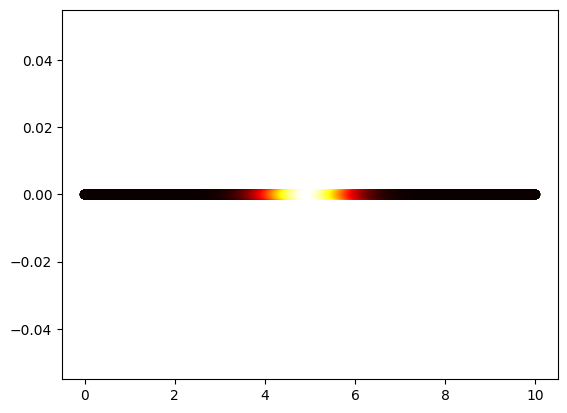

In [2]:
# =============
# TEMPERATURA INICIAL DE LA BARRA

L = 10
N = 10000
alpha = 1       # coeficiente de difusion termica
thickness = 50  # grosor de la linea

# Malla espacial
x = torch.linspace(0, L, N)

# Condicion inicial
u0 = torch.exp(- ((x - L/2)**2) )  # distribucion Gaussiana de temperatura

# Scatter plot con colores segun la temperatura
plt.figure(dpi=100)
plt.scatter(x, np.zeros_like(x), c=u0.numpy(), cmap='hot', s=thickness, edgecolors='none')

In [3]:
# =============
# DEFINICION DEL MODELO

def gradients(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True)
    return grads

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# Parametros fisicos y de entrenamiento
alpha = 1            # coeficiente de difusion termica
L = 10               # dominio [0,10] en x
T_MAX = 10           # tiempo maximo
N_STEPS = 2500       # numero de iteraciones de entrenamiento
N_COLLOC = 25000     # numero de muestras para la PDE
N_BC = 25000         # numero de muestras para la condicion inicial y de frontera

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicion de la MLP para approximar Psi(x,y,t)
class HEAT(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, layers[0]),
            Sine(),
            *sum([[nn.Linear(layers[i], layers[i+1]), Sine()]
                  for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)

# class HEAT(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(2, layers[0]),
#             nn.ReLU(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.ReLU()]
#                     for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# class HEAT(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(2, layers[0]),
#             nn.Tanh(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# Inicializar red, optimizador y scheduler
mlp = HEAT([100,100,100,100,100,100,100,100]).to(device)                            
mse = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                milestones=[2500, 5000, 7500, 10000, 20000], gamma=0.25)

print(f"Modelo inicializado correctamente en {device}.")

Modelo inicializado correctamente en cuda.


In [4]:
# =============
# BUCLE DE ENTRENAMIENTO

# Parametros
EXTRA_EPOCHS = 0
lambda_ic    = 1000
lambda_bc    = 10
# lambda_ic    = 1
# lambda_bc    = 1
model_path   = 'models/heat/lambdas/heat'
os.makedirs(model_path, exist_ok=True)

# Carga de checkpoint previo
if os.path.exists(f"{model_path}.pth"):
    ckpt = torch.load(f"{model_path}.pth", map_location=device)
    mlp.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch   = ckpt['epoch']
    print(f"Cargado checkpoint de la época {start_epoch-1:02d}.")
else:
    start_epoch   = 1
    print("No hay checkpoint previo. Empezando desde epoch 01.")

N_EPOCHS = start_epoch + EXTRA_EPOCHS

for epoch in range(start_epoch, N_EPOCHS):
    mlp.train()
    epoch_loss = 0.0

    # Bucle con tqdm
    loop = tqdm(range(1, N_STEPS+1),
                desc=f"Epoch {epoch:02d}",
                unit="step",
                delay=0.1,
                total=N_STEPS)

    for step in loop:
        # Generar muestras aleatorias de (x, t) en el dominio
        x = torch.rand(N_COLLOC, 1, device=device) * L
        t = torch.rand(N_COLLOC, 1, device=device) * T_MAX
        X = torch.cat([x, t], dim=1).requires_grad_(True)

        # Evaluacion de la red para obtener u(x, t)
        u = mlp(X)[:, 0].unsqueeze(1) # [N,1]

        # Calculo de gradientes para obtener las parciales
        grads = gradients(u, X)
        du_dt = grads[:, 1].unsqueeze(1)
        grads2 = gradients(grads[:, 0].unsqueeze(1), X)
        d2u_dx2 = grads2[:, 0].unsqueeze(1)

        # Perdida de la ecuación del calor
        loss_pde = mse(du_dt, alpha * d2u_dx2) # [N,1], [N,1]

        # Condicion inicial
        x0 = torch.rand(N_BC, 1, device=device) * L
        t0 = torch.zeros(N_BC, 1, device=device)
        u0 = torch.exp(- ((x0 - L/2)**2) )  # estado inicial de temperatura [N,1]
        X0 = torch.cat([x0, t0], dim=1).requires_grad_(True)
        
        u0_hat = mlp(X0)[:, 0].unsqueeze(1) # [N,1]
        loss_ic = lambda_ic*mse(u0_hat, u0)
        
        # Condiciones de frontera Dirichlet
        xb = torch.tensor([0, L], device=device).repeat(N_BC, 1).flatten()
        tb = torch.rand(N_BC * 2, device=device) * T_MAX
        Xb = torch.stack([xb, tb], axis=-1)
        ub = mlp(Xb)[:, 0].unsqueeze(1) # [N,1]
        loss_bc = lambda_bc*mse(ub, torch.zeros_like(ub))

        # Optimizacion
        optimizer.zero_grad()
        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        # Mostrar metricas en la barra
        loop.set_postfix({
            "pde": f"{loss_pde.item():.2e}",
            "ic":  f"{loss_ic.item():.2e}",
            "bc":  f"{loss_bc.item():.2e}"
        })

    # Promedio de loss de la epoch
    avg_epoch_loss = epoch_loss / N_STEPS
    print(f"Epoch {epoch:02d} concluida — avg loss: {avg_epoch_loss:.3e} — lr: {optimizer.param_groups[0]['lr']}")

    # Guardar checkpoint de la epoca
    checkpoint_path = f"{model_path}_{epoch:02d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_pde': loss_pde,
        'loss_ic': loss_ic/lambda_ic,
        'loss_bc': loss_bc/lambda_bc
    }, checkpoint_path)

    # Guardar checkpoint general
    checkpoint_path = f"{model_path}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

print("Entrenamiento completado.")

Cargado checkpoint de la época 10.
Entrenamiento completado.


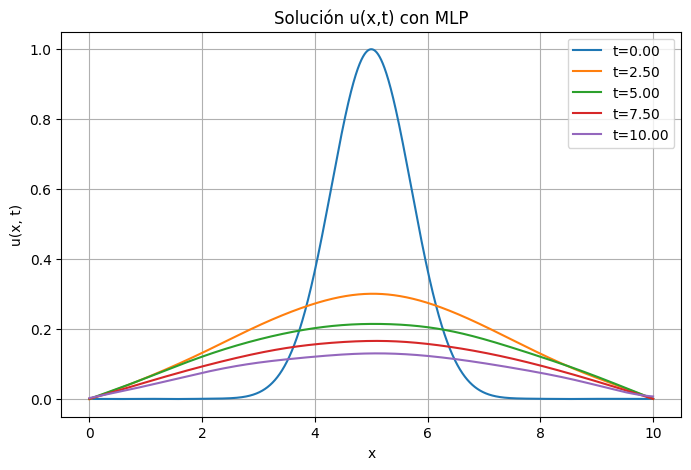

In [5]:
# =============
# REPRESENTACION DE LA SOLUCION MLP

# Parametros
L   = 10.0         # longitud en x
Nx  = 10000        # puntos en x
tf  = 10.0         # tiempo final
Nt  = 10000        # numero de pasos en t
dt  = tf / (Nt - 1)

# Discretizacion espacial y temporal
x = np.linspace(0, L, Nx)         # (Nx,)
t = np.linspace(0, tf, Nt)        # (Nt,)

# Construir malla (Nt x Nx) y aplanar
X_grid, T_grid = np.meshgrid(x, t, indexing='xy')        # (Nt, Nx)
XT = np.stack([X_grid.ravel(), T_grid.ravel()], axis=1)  # (Nt*Nx, 2)
XT = torch.from_numpy(XT).float()

# Preparar modelo y dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp.to(device)
XT = XT.to(device)

# Poner en modo evaluacion y trazar con TorchScript
mlp.eval()
example = torch.zeros(1, 2, dtype=XT.dtype, device=device)
traced_mlp = torch.jit.trace(mlp, example)

# Inferencia por chunks para no saturar la memoria
batch_size = 200_000
out_parts = []
with torch.no_grad():
    for i in range(0, XT.size(0), batch_size):
        chunk = XT[i:i+batch_size]
        y = traced_mlp(chunk)[:, 0].cpu()
        out_parts.append(y)
U_flat = torch.cat(out_parts).numpy()

# Reconstruir matriz (Nt, Nx)
U = U_flat.reshape(Nt, Nx)

# Graficar cortes para varios instantes
plt.figure(figsize=(8, 5))
for idx in [0, Nt//4, Nt//2, 3*Nt//4, -1]:
    plt.plot(x, U[idx], label=f"t={t[idx]:.2f}")
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Solución u(x,t) con MLP')
plt.legend()
plt.grid(True)
plt.show()

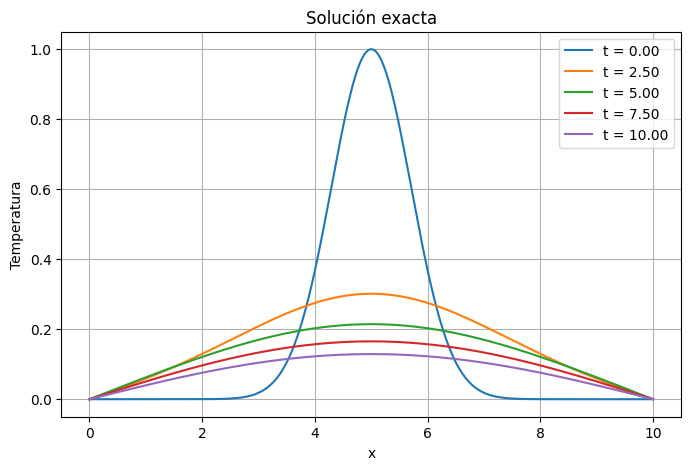

In [6]:
from scipy.integrate import quad

# Parametros
L = 10.0
Nx = 10000
alpha = 1
x = np.linspace(0, L, Nx)
N_terms = 50

def u0(y):
    return np.exp(-y**2)

def compute_bn(n):
    integrand = lambda y: u0(y - L/2) * np.sin(n * np.pi * y / L)
    bn, _ = quad(integrand, 0, L)
    return (2.0 / L) * bn

b = np.array([compute_bn(n) for n in range(1, N_terms + 1)])

def heat_solution_dirichlet(x, t, N_terms=N_terms):
    u = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        u += b[n-1] * np.sin(n * np.pi * x / L) * np.exp(- (n * np.pi / L)**2 * alpha * t)
    return u

# Parametros temporales
tf = 10.0
n_snapshots = 5

tiempos_snapshot = np.linspace(0, tf, n_snapshots)
solutions_snap = [heat_solution_dirichlet(x, t) for t in tiempos_snapshot]

# Plot unico con todas las curvas
plt.figure(figsize=(8, 5))
for t, perfil in zip(tiempos_snapshot, solutions_snap):
    plt.plot(x, perfil, label=f't = {t:.2f}')

plt.xlabel('x')
plt.ylabel('Temperatura')
plt.title('Solución exacta')
plt.legend()
plt.grid(True)
plt.show()